##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="../images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

In [2]:
!pip install -Uq "google-generativeai>=0.7.2"

In [3]:
import google.generativeai as genai


import pathlib
import tqdm
import os

## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [4]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

## Download and inspect the PDF

Install the PDF processing tools. You don't need these to use the API, it's just used to display a screenshot of a page.

In [5]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (214 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


This PDF page is an article titled [Smoothly editing material properties of objects with text-to-image models and synthetic data](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) available on the Google Research Blog.

In [6]:
if not pathlib.Path('test.pdf').exists():
  !curl -o test.pdf https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6538k  100 6538k    0     0  13.7M      0 --:--:-- --:--:-- --:--:-- 13.7M


Look at one of the pages:

In [7]:
!pdftoppm test.pdf -f 1 -l 1 page-image -jpeg
!ls

page-image-1.jpg  sample_data  test.pdf


In [8]:
import PIL.Image

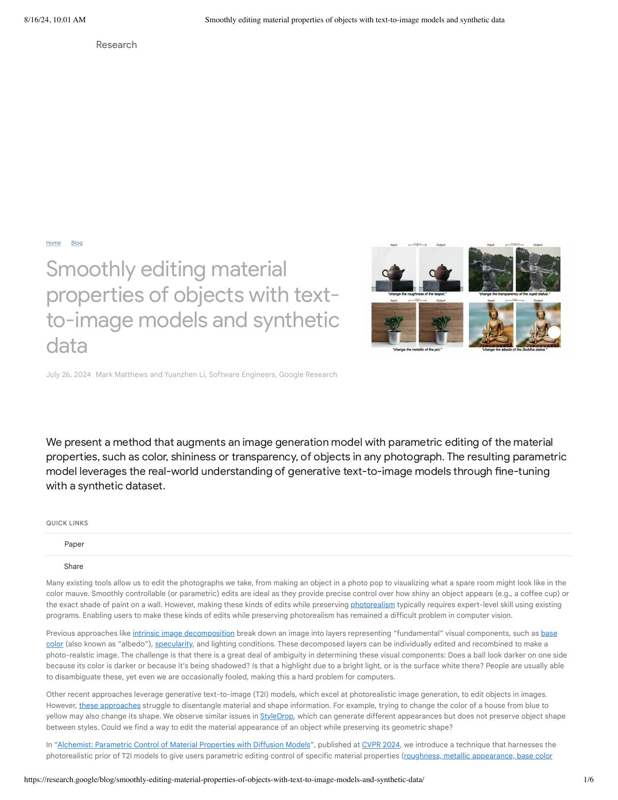

In [9]:
img = PIL.Image.open(f"page-image-1.jpg")
img.thumbnail([800, 800])
img

## Upload the file to the API

In [10]:
file_ref = genai.upload_file('test.pdf')

## Try it out

In [11]:
model = genai.GenerativeModel(model_name='gemini-2.0-flash')

The pages of the PDF file are each passed to the model as a screenshot of the page plus the text extracted by OCR.

In [12]:
model.count_tokens([file_ref, '\n\nCan you summarize this file as a bulleted list?'])

total_tokens: 4431

In [13]:
response = model.generate_content(
    [file_ref, '\n\nCan you summarize this file as a bulleted list?']
)

In [14]:
from IPython.display import Markdown
Markdown(response.text)

Here is a summary of the document provided, presented in bulleted format:

*   **Topic:** The document discusses a method to edit material properties (e.g., color, shininess, transparency) of objects in images using text-to-image models and synthetic data.
*   **Problem Addressed:** Traditional methods for these edits require expert skill to maintain photorealism. Existing approaches can also struggle to disentangle material from shape information.
*   **Proposed Solution:** The presented method augments an image generation model with parametric editing, fine-tuning it on a synthetic dataset where material properties are controlled.
*   **Method:**
    *   Uses traditional computer graphics to render a synthetic dataset with controlled material attributes (roughness, metallic, albedo, transparency).
    *   Modifies the architecture of Stable Diffusion 1.5 to accept edit strength values for parameter control.
    *   Fine-tunes the model on the synthetic dataset, inputting context image, instruction, and edit strength.
*   **Results:** The model successfully edits material appearances while preserving shape and lighting in real-world images.
*   **User Study:**  The presented approach was compared to InstructPix2Pix and was shown to produce more realistic and overall better edits.
*   **Applications:** The technology can be used for imagining different paint colors in rooms, prototyping product designs, and consistent editing of 3D tasks through NeRF reconstruction.
*   **Acknowledgements:** The article credits individuals for their work and contributions.


In addition, take a look at how the Gemini model responds when you ask questions about the images within the PDF.

In [15]:
response_2 = model.generate_content(
    [file_ref, '\n\nCan you explain the images on the first page of the document?']
)

In [16]:
from IPython.display import Markdown
Markdown(response_2.text)

Here's a description of the images on the first page of the document, based on the OCR text:

*   **Top:** The top left image is an "input" of "change the roughness of the teapot." and the top right image is the "output" based on that prompt.
*   **Middle:** The middle left image is an "input" of "change the metallic of the pot.", while the middle right image is the "output" based on the prompt.
*   **Bottom:** The bottom left image is an "input" of "change the albedo of the Buddha statue.", while the bottom right image is the "output" based on the prompt.

If you observe the area of the header of the article, you can see that the model captures what is happening.

## Learning more

The File API lets you upload a variety of multimodal MIME types, including images, audio, and video formats. The File API handles inputs that can be used to generate content with `model.generateContent` or `model.streamGenerateContent`.

The File API accepts files under 2GB in size and can store up to 20GB of files per project. Files last for 2 days and cannot be downloaded from the API.

* Learn more about prompting with [media files](https://ai.google.dev/gemini-api/docs/file-prompting-strategies) in the docs, including the supported formats and maximum length.
* Learn more about to extract structured outputs from PDFs in the [Structured outputs on invoices and forms](https://github.com/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) example.
